In [1]:
import pandas as pd
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import librosa
import librosa.display
import IPython.display as ipd

In [3]:
filename='sound/1620627399144-recording-1.wav'

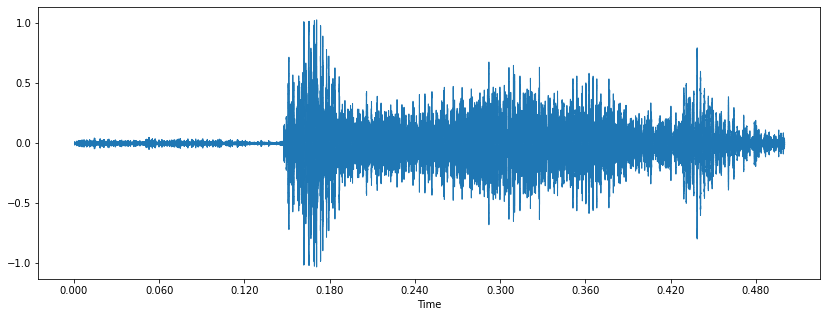

In [4]:
 ## Sample visualization
plt.figure(figsize=(14,5))
librosa_data,librosa_sample_rate=librosa.load(filename)
librosa.display.waveshow(librosa_data,sr=librosa_sample_rate)
ipd.Audio(filename)

In [5]:
librosa_data,librosa_sample_rate=librosa.load(filename)
mfccs=librosa.feature.mfcc(y=librosa_data,sr=librosa_sample_rate,n_mfcc=40)

In [6]:
librosa_data.shape

(11025,)

In [7]:
import pandas as pd
Metadata=pd.read_csv("original.csv")
Metadata.head(10)

,participant,filename,sound_prediction_score,tb_status
0,CODA_TB_0001,1645088710003-recording-1.wav,0.990254,0
1,CODA_TB_0001,1645088760390-recording-1.wav,0.990272,0
2,CODA_TB_0001,1645088760830-recording-1.wav,0.990112,0
3,CODA_TB_0001,1645088710843-recording-1.wav,0.990152,0
4,CODA_TB_0001,1645088759950-recording-1.wav,0.990039,0
5,CODA_TB_0001,1645088758630-recording-1.wav,0.990004,0
6,CODA_TB_0001,1645088758230-recording-1.wav,0.975063,0
7,CODA_TB_0001,1645088738844-recording-1.wav,0.990068,0
8,CODA_TB_0001,1645088784942-recording-1.wav,0.990291,0
9,CODA_TB_0001,1645088784542-recording-1.wav,0.990288,0


In [8]:
mfccs=librosa.feature.mfcc(y=librosa_data,sr=librosa_sample_rate,n_mfcc=40)
print(mfccs.shape)

(40, 22)


In [9]:
# def features_extractor(file,num_frames):
#     audio, sample_rate = librosa.load(file) 
#     mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
#     if mfccs_features.shape[1] < num_frames:
#         mfccs_features = np.pad(mfccs_features, ((0, 0), (0, num_frames - mfccs_features.shape[1])), mode="constant")
#     else:
#         mfccs_features = mfccs_features[:, :num_frames]
#     return mfccs_features

def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type = "kaiser_fast")
    mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
    return mfccs_scaled_features

In [10]:
import numpy as np
from tqdm import tqdm
x=[]
y=[]
extracted_features=[]
#max_frames = 22  # define fixed number of frames
for index_num,row in tqdm(Metadata.iterrows()):
    class_id= row["tb_status"]
    path="sound/{}".format(row["filename"])
    mfccs=features_extractor(path)
    x.append(mfccs)
    y.append(class_id)

27368it [10:24, 43.82it/s]


In [11]:
# import json
# x_array=np.array(x)
# y_array=np.array(y)
# x_list = x_array.tolist()
# y_list = y_array.tolist()

# data = {
#     "features": x_list,
#     "labels": y_list
# }

# with open('features.json', 'w') as f:
#     json.dump(data, f)

In [12]:
from tensorflow.keras.utils import to_categorical
# convert input data to numpy array
x = np.array(x)

# convert labels to numpy array
y = to_categorical(np.array(y))  # convert to one-hot encoded format

In [13]:
print(x.shape)
print(y.shape)

(27368, 40)
(27368, 2)


In [14]:
# split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=42)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21894, 40)
(5474, 40)
(21894, 2)
(5474, 2)


In [16]:
X_train = X_train.reshape(X_train.shape[0], 8, 5, 1)
X_test = X_test.reshape(X_test.shape[0], 8, 5, 1)

In [17]:
print(X_train.shape)
print(X_test.shape)
input_dim=(8,5,1)

(21894, 8, 5, 1)
(5474, 8, 5, 1)


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam

In [19]:
model = Sequential()

model.add(Conv2D(32, (2, 2), activation='relu', input_shape = input_dim))
model.add(MaxPooling2D((1, 1)))

model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D((1, 1)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (2, 2), activation='relu'))
model.add(MaxPooling2D((1, 1)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [20]:
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
# train model
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1)

Epoch 1/20
616/616 [==============================] - 10s 16ms/step - loss: 0.0972 - accuracy: 0.9636 - val_loss: 0.1421 - val_accuracy: 0.9562
Epoch 2/20
616/616 [==============================] - 10s 16ms/step - loss: 0.1056 - accuracy: 0.9613 - val_loss: 0.1341 - val_accuracy: 0.9612
Epoch 3/20
616/616 [==============================] - 10s 16ms/step - loss: 0.0869 - accuracy: 0.9674 - val_loss: 0.1346 - val_accuracy: 0.9594
Epoch 4/20
616/616 [==============================] - 10s 16ms/step - loss: 0.0905 - accuracy: 0.9668 - val_loss: 0.1471 - val_accuracy: 0.9543
Epoch 5/20
616/616 [==============================] - 10s 16ms/step - loss: 0.0890 - accuracy: 0.9671 - val_loss: 0.1294 - val_accuracy: 0.9571
Epoch 6/20
616/616 [==============================] - 10s 17ms/step - loss: 0.0861 - accuracy: 0.9693 - val_loss: 0.1515 - val_accuracy: 0.9580
Epoch 7/20
616/616 [==============================] - 10s 17ms/step - loss: 0.0829 - accuracy: 0.9695 - val_loss: 0.1545 - val_accuracy:

In [26]:
# Evaluate the model
score = model.evaluate(X_test, y_test,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11878478527069092
Test accuracy: 0.9630982875823975


In [23]:
# model.evaluate(X_train,y_train)

685/685 [==============================] - 3s 5ms/step - loss: 0.0371 - accuracy: 0.9917


[0.03707648068666458, 0.9917328953742981]

In [24]:
# model.save("mfcc_model")